In [1]:
import pandas as pd 
import numpy as np 
from utils import * 
from src import get_genome_id
import os
from src.files import FASTAFile, InterProScanFile, GBFFFile
import subprocess
import glob
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2

In [ ]:
genome_ids = pd.read_csv('../data/campylobacterota_dataset.csv', index_col=0).genome_id.unique()
results = Results(genome_ids, load_ref=True, load_labels=True)
genome_metadata = pd.read_csv('../data/genome_metadata.csv', index_col=0)

In [3]:
has_hit = lambda df : (df.reason == 'needs manual validation')
has_no_hit = lambda df : (df.reason == 'no InterProScan hit')
has_antifam_hit = lambda df: (df.reason == 'AntiFam InterProScan hit')

is_intergenic_no_hit = lambda df : has_no_hit(df) & (df.category == 'intergenic')
is_intergenic_hit = lambda df : has_hit(df) & (df.category == 'intergenic')
is_conflict_no_hit = lambda df : has_no_hit(df) & (df.category == 'conflict')
is_conflict_hit = lambda df : has_hit(df) & (df.category == 'conflict')  

is_spurious = lambda df : df.label == 'spurious'

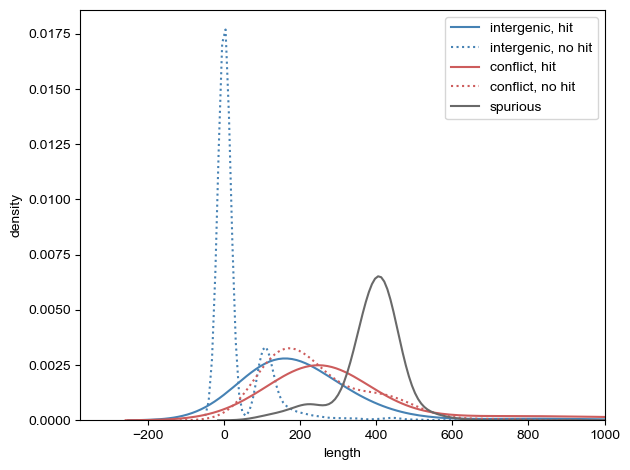

In [4]:
def figure_1(results, max_length:int=1000):
    df = results.to_df()
    df = df[df.reason != 'suspect top hit'].copy()
    df = df[df.query_length // 3 < max_length].copy()

    fig = plt.figure(layout='tight')
    ax = fig.add_subplot()

    colors = ['steelblue', 'steelblue', 'indianred', 'indianred', 'dimgray']
    linestyles = ['-', ':', '-', ':', '-']
    categories = ['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'spurious']
    masks = [is_intergenic_hit(df), is_intergenic_no_hit(df), is_conflict_hit(df), is_conflict_no_hit(df), is_spurious(df)]

    ax_df = df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[ax_df.category != 'none'].copy()
    ax_df = ax_df[['category', 'query_length']]
    ax_df = ax_df.rename(columns={'query_length':'length'})

    for category, color, linestyle in zip(categories, colors, linestyles):
        sns.kdeplot(data=ax_df[ax_df.category == category], x='length', ax=ax, linewidth=1.5, linestyle=linestyle, color=color, label=category, common_norm=False)
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlim(xmax=1000)
    plt.show()

figure_1(results)


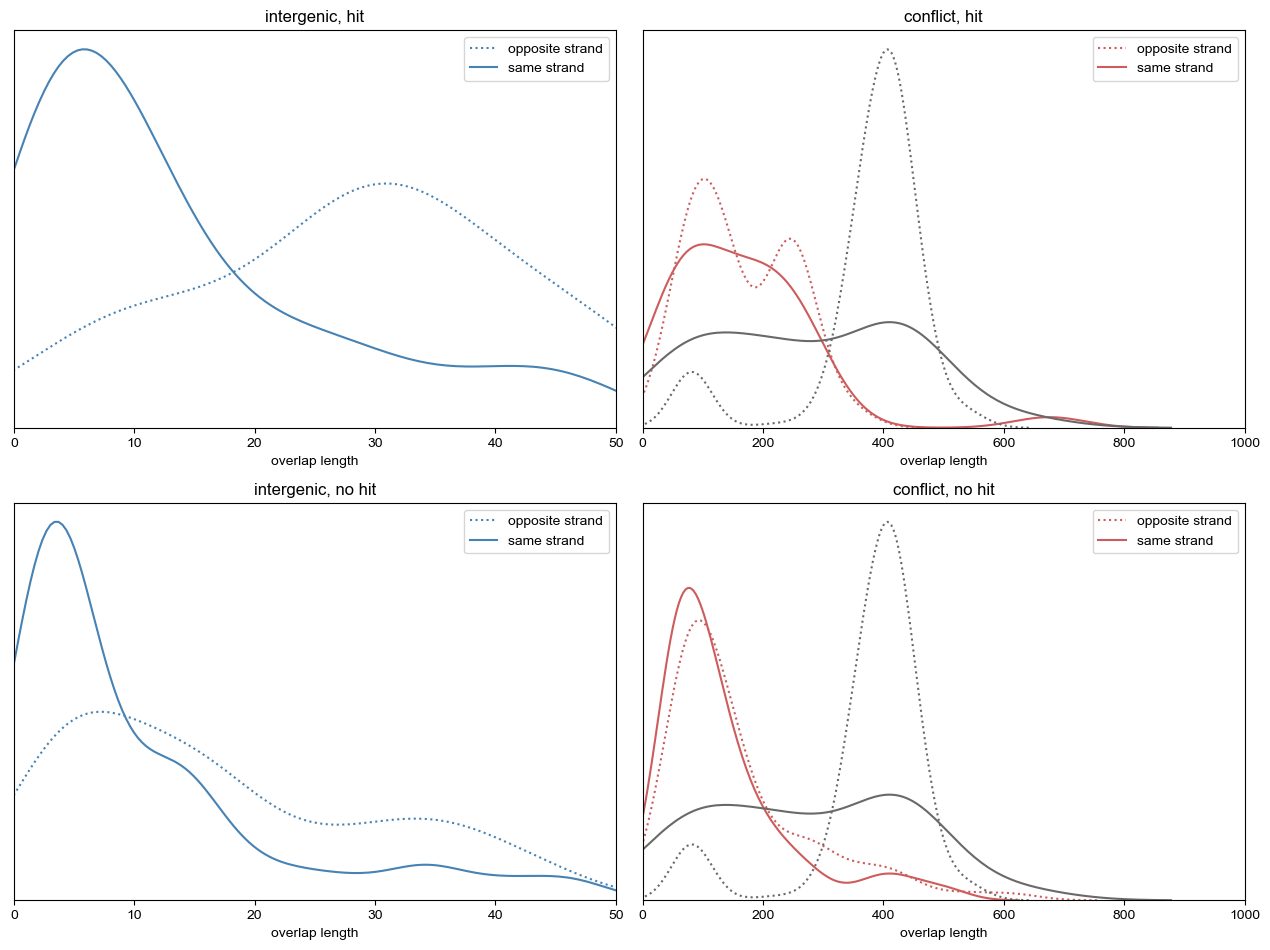

In [11]:
# What fraction of the overlaps with hits are on the same strand?
# Conflict overlaps can be on the same strand, just won't be in-frame. 
# Want to characterize the overlaps and length profiles of the different categories. 
# Are there any patterns in what can or cannot be labeled?
# What are the differences in the overlap profiles for hits on the same or opposite strands?

def figure_2(results, max_length:int=1000, overlap_metric='overlap_length'):
    df = results.to_df()
    df = df[df.reason != 'suspect top hit'].copy()
    df = df[df.query_length // 3 < max_length].copy()

    fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2), layout='tight')
    grid = GridSpec(figure=fig, nrows=2, ncols=2, width_ratios=[0.5, 0.5])
    ax = list()
    ax.append(fig.add_subplot(grid[0, 0], xlim=(0, 50)))
    ax.append(fig.add_subplot(grid[1, 0], sharex=ax[-1]))
    ax.append(fig.add_subplot(grid[0, 1], xlim=(0, 1000)))
    ax.append(fig.add_subplot(grid[1, 1], sharex=ax[-1]))

    colors = ['steelblue', 'steelblue', 'indianred', 'indianred']
    categories = ['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'spurious']
    masks = [is_intergenic_hit(df), is_intergenic_no_hit(df), is_conflict_hit(df), is_conflict_no_hit(df), is_spurious(df)]

    ax_df = df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[ax_df.category != 'none'].copy()
    ax_df = ax_df[['category', overlap_metric, 'same_strand']]
    ax_df = ax_df[ax_df[overlap_metric] > 0].copy() # Only looking at intergenic hits with some overlap. 
    ax_df = ax_df.rename(columns={overlap_metric:overlap_metric.replace('_', ' ')})
    overlap_metric = overlap_metric.replace('_', ' ')

    for ax_, category, color in zip(ax, categories[:-1], colors):
        df_ = ax_df[ax_df.category == category]
        sns.kdeplot(data=df_[~df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle=':', color=color, label='opposite strand', common_norm=False)
        sns.kdeplot(data=df_[df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle='-', color=color, label='same strand', common_norm=False)
        ax_.set_title(category, fontsize='large')
        ax_.set_yticks([])
        ax_.set_ylabel('')
        ax_.legend()
        ax_.set_xlabel(overlap_metric)

    for ax_ in ax[2:]:
        df_ = ax_df[ax_df.category == 'spurious']
        sns.kdeplot(data=df_[~df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle=':', color='dimgray',  common_norm=False)
        sns.kdeplot(data=df_[df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle='-', color='dimgray',  common_norm=False) 

    plt.show()

figure_2(results)

figure_2: Discarding 1757 intergenic sequences with no overlap.


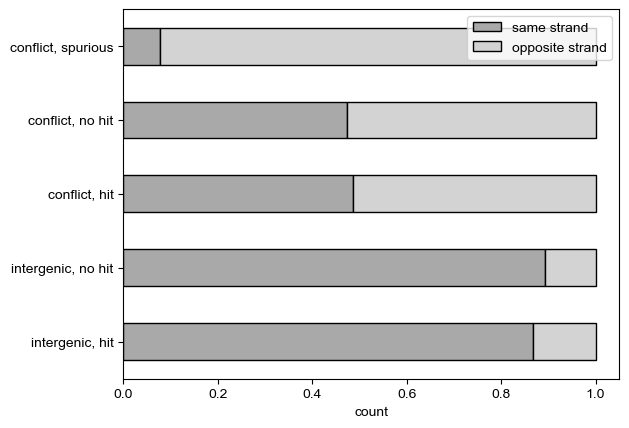

In [ ]:
def figure_2(results, normalize:bool=True):
    df = results.to_df()
    df = df[df.category.isin(['intergenic', 'conflict'])].copy()
    print(f'figure_2: Discarding {(df.overlap_length > 0).sum()} intergenic sequences with no overlap.')
    df = df[df.overlap_length > 0].copy()

    fig = plt.figure()
    ax = fig.add_subplot()

    categories = np.array(['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'conflict, spurious'])
    masks = [is_intergenic_hit(df), is_intergenic_no_hit(df), is_conflict_hit(df), is_conflict_no_hit(df), is_spurious(df)]

    ax_df = pd.DataFrame(columns=['same strand', 'opposite strand'], index=categories)
    for category, mask in zip(categories, masks):
        df_ = df[mask]
        ax_df.loc[category, 'same strand'] = df_.same_strand.sum()
        ax_df.loc[category, 'opposite strand'] = ((df_.n_hits > 0) & (~df_.same_strand)).sum()

    if normalize:
        ax_df = ax_df / ax_df.values.sum(axis=1).reshape(-1, 1)
    ax_df.plot(kind='barh', stacked=True, color=['darkgray', 'lightgray'], ax=ax, edgecolor='black')
    ax.set_xlabel('count')

    plt.show()

figure_2(results)


figure_3: Discarding 1757 intergenic sequences with no overlap.


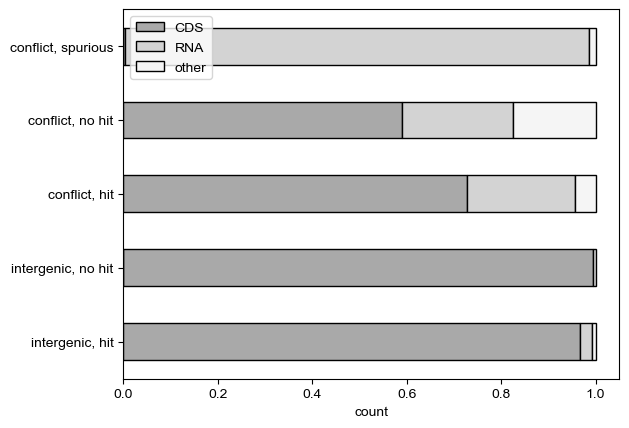

In [ ]:
def figure_3(results, normalize:bool=True):
    df = results.to_df()
    df = df[df.category.isin(['intergenic', 'conflict'])].copy()
    print(f'figure_3: Discarding {(df.overlap_length > 0).sum()} intergenic sequences with no overlap.')
    df = df[df.overlap_length > 0].copy()

    fig = plt.figure()
    ax = fig.add_subplot()

    categories = np.array(['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'conflict, spurious'])
    masks = [is_intergenic_hit(df), is_intergenic_no_hit(df), is_conflict_hit(df), is_conflict_no_hit(df), is_spurious(df)]

    ax_df = pd.DataFrame(columns=['CDS', 'RNA', 'other'], index=categories)
    for category, mask in zip(categories, masks):
        df_ = df[mask]
        ax_df.loc[category, 'CDS'] = df_.top_hit_feature.isin(GBFFFile.coding_features).sum()
        ax_df.loc[category, 'RNA'] = df_.top_hit_feature.isin(GBFFFile.rna_features).sum()
        ax_df.loc[category, 'other'] = df_.top_hit_feature.isin(GBFFFile.other_features).sum()

    if normalize:
        ax_df = ax_df / ax_df.values.sum(axis=1).reshape(-1, 1)

    ax_df.plot(kind='barh', stacked=True, color=['darkgray', 'lightgray', 'whitesmoke'], ax=ax, edgecolor='black')
    ax.set_xlabel('count')

    plt.show()

figure_3(results)

figure_4: 96 out of 196 genomes have no labeled spurious sequences.


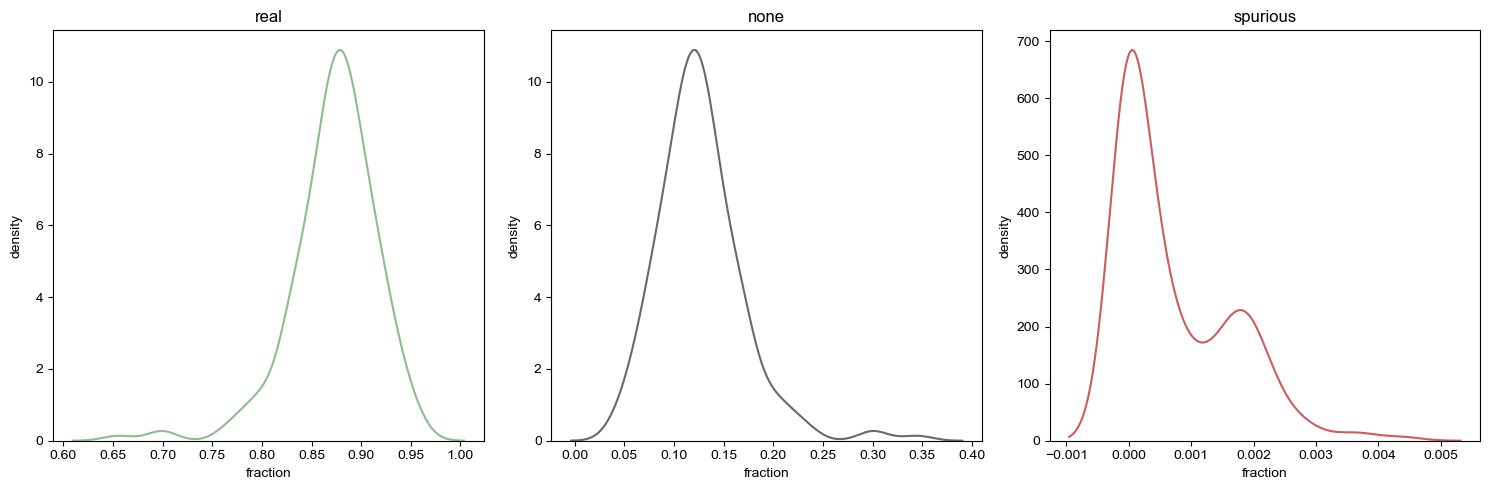

In [30]:
# What is the distribution of successful labels across genomes?

def figure_4(results, path:str=None):

    df = results.to_df()

    fig = plt.figure(layout='tight', figsize=(15, 5))
    grid = GridSpec(figure=fig, ncols=3, nrows=1)
    axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[0, 2])]

    ax_df = pd.DataFrame(index=df.groupby('genome_id').genome_id.first())
    for label in df.label.unique():
        ax_df[f'frac_{label}'] = df.groupby('genome_id').apply(lambda df_ : (df_.label == label).mean(), include_groups=False)
        ax_df[f'num_{label}'] = df.groupby('genome_id').apply(lambda df_ : (df_.label == label).sum(), include_groups=False)

    print(f'figure_4: {(ax_df.num_spurious == 0).sum()} out of {len(ax_df)} genomes have no labeled spurious sequences.')

    colors = {'none':'dimgray', 'real':'darkseagreen', 'spurious':'indianred'}
    for label, ax in zip(df.label.unique(), axes):
        sns.kdeplot(data=ax_df, x=f'frac_{label}', ax=ax, color=colors[label])
        ax.set_ylabel('density')
        ax.set_xlabel('fraction')
        ax.set_title(label)

    plt.show()

    
figure_4(results)